# Segformer

Research Paper: https://arxiv.org/abs/2105.15203

Datasets: https://data.mendeley.com/datasets/8gf9vpkhgy/2

Implementation adapted from:
1. https://github.com/NVlabs/SegFormer
2. https://debuggercafe.com/road-segmentation-using-segformer/
3. https://www.kaggle.com/code/andrewkettle/pytorch-segformer-and-sam-on-kindey-1
4. https://medium.com/geekculture/semantic-segmentation-with-segformer-2501543d2be4

In [18]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, recall_score, jaccard_score, precision_score
import matplotlib.pyplot as plt

pre_trained_model = 'nvidia/mit-b0'

## Section 1: Datasets Processing

In [19]:
class Process_Datasets(Dataset):
    def __init__(self, root_dir, image_processor):
        self.root_dir = root_dir
        self.image_processor = image_processor

        self.image_path = os.path.join(self.root_dir, "img")
        self.mask_path = os.path.join(self.root_dir, "mask")

        image_files = [f for f in os.listdir(self.image_path) if '.png' in f]
        mask_files = [f for f in os.listdir(self.mask_path) if '.png' in f]
        self.images = sorted(image_files)
        self.masks = sorted(mask_files)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.image_path, self.images[index])
        mask_path = os.path.join(self.mask_path, self.masks[index])

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        encoded = self.image_processor(image, mask, return_tensors="pt")

        for k,v in encoded.items():
            encoded[k].squeeze_()

        return encoded

In [20]:
def load_datasets(root_dir):
    batch_size=4
    image_processor = SegformerImageProcessor.from_pretrained(pre_trained_model)
    image_processor.do_reduce_labels = False
    image_processor.size = 128

    dataset = Process_Datasets(root_dir=root_dir, image_processor=image_processor)
    train, val = train_test_split(dataset, test_size=0.2)
    val, test = train_test_split(val, test_size=0.01)

    train_dataset = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataset = DataLoader(val, batch_size=batch_size, shuffle=True)
    test_dataset = DataLoader(test, shuffle=True)

    return train_dataset, val_dataset, test_dataset

### Part 1: Darwin Dataset

In [21]:
darwin_train, darwin_val, darwin_test = load_datasets(root_dir="./Datasets/Darwin")
len(darwin_train), len(darwin_val), len(darwin_test)

(1221, 303, 13)

### Part 2: Shenzhen Dataset

In [22]:
shenzhen_train, shenzhen_val, shenzhen_test = load_datasets(root_dir="./Datasets/Shenzhen")
len(shenzhen_train), len(shenzhen_val), len(shenzhen_test)

(113, 28, 2)

### Part 3: Covid-19 Dataset

In [23]:
covid_train, covid_val, covid_test = load_datasets(root_dir="./Datasets/COVID-19/COVID")
len(covid_train), len(covid_val), len(covid_test)

(723, 179, 8)

## Section 2: Model Implementation

In [24]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def metrics_calculations(pred_mask, true_mask):
    iou = jaccard_score(true_mask.flatten(), pred_mask.flatten(), average='weighted')
    accuracy = accuracy_score(true_mask.flatten(), pred_mask.flatten())
    precision = precision_score(true_mask.flatten(), pred_mask.flatten(), average='weighted')
    recall = recall_score(true_mask.flatten(), pred_mask.flatten(), average='weighted')
    f1 = f1_score(true_mask.flatten(), pred_mask.flatten(), average='weighted')

    return iou, accuracy, precision, recall, f1

def train_model(train_data, val_data):
    epochs = 15

    model = SegformerForSemanticSegmentation.from_pretrained(pre_trained_model, ignore_mismatched_sizes=True)
    optimizer = optim.Adam(model.parameters(), lr=0.0025)
    val_metrics = []

    # Train network
    for ep in range(epochs):
        train_loss = []
        val_loss = []

        model.train()
        for index, batch in enumerate(tqdm(train_data)):
            image = batch["pixel_values"]
            mask = batch["labels"]
            optimizer.zero_grad()
            
            outputs = model(pixel_values=image, labels=mask)
            loss = outputs.loss

            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for index, batch in enumerate(tqdm(val_data)):
                image = batch["pixel_values"]
                mask = batch["labels"]
                optimizer.zero_grad()

                outputs = model(pixel_values=image, labels=mask)
                logits = F.interpolate(outputs.logits, size=mask.shape[-2:], mode="bilinear", align_corners=False)
                prediction = logits.argmax(dim=1)

                for pred, true in zip(prediction, mask):
                    pred_mask = pred.cpu().numpy()
                    true_mask = true.cpu().numpy()

                    iou, accuracy, precision, recall, f1 = metrics_calculations(pred_mask, true_mask)
                    val_metrics.append([iou, accuracy, precision, recall, f1])

                loss = outputs.loss
                val_loss.append(loss.item())
                optimizer.step()

        print(f"Epoch [{ep+1}/{epochs}]. Training Loss [{np.mean(train_loss)}]. Validation Loss [{np.mean(val_loss)}]")

    metrics = pd.DataFrame(val_metrics, columns=["IoU", "Accuracy", "Precision", "Recall", "F1"])
    return model, metrics

### Part 1: Darwin Dataset

In [25]:
darwin_model, darwin_metrics = train_model(darwin_train, darwin_val)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 303/303 [01:23<00:00,  3.64it/s]


Epoch [1/15]. Training Loss [0.11481892463066946]. Validation Loss [0.06186079793293091]


100%|██████████| 303/303 [01:26<00:00,  3.49it/s]


Epoch [2/15]. Training Loss [0.06030352865052116]. Validation Loss [0.06003346522845844]


100%|██████████| 303/303 [01:27<00:00,  3.48it/s]


Epoch [3/15]. Training Loss [0.0585901175719441]. Validation Loss [0.05705841456727423]


100%|██████████| 303/303 [01:26<00:00,  3.49it/s]


Epoch [4/15]. Training Loss [0.05815950878434353]. Validation Loss [0.05671223334771375]


100%|██████████| 303/303 [01:23<00:00,  3.62it/s]


Epoch [5/15]. Training Loss [0.05735700343026918]. Validation Loss [0.05770912159713778]


100%|██████████| 303/303 [01:26<00:00,  3.48it/s]


Epoch [6/15]. Training Loss [0.05727040387665659]. Validation Loss [0.057633543282550555]


100%|██████████| 303/303 [01:27<00:00,  3.47it/s]


Epoch [7/15]. Training Loss [0.05670582933426147]. Validation Loss [0.057116281923533664]


100%|██████████| 303/303 [01:24<00:00,  3.60it/s]


Epoch [8/15]. Training Loss [0.05629872114997873]. Validation Loss [0.056184830334615396]


100%|██████████| 303/303 [01:23<00:00,  3.62it/s]


Epoch [9/15]. Training Loss [0.05712899210558477]. Validation Loss [0.055925769878938644]


100%|██████████| 303/303 [01:25<00:00,  3.54it/s]


Epoch [10/15]. Training Loss [0.05579060197553851]. Validation Loss [0.05804830085695183]


100%|██████████| 303/303 [01:23<00:00,  3.62it/s]


Epoch [11/15]. Training Loss [0.05556409000239833]. Validation Loss [0.05582550765559225]


100%|██████████| 303/303 [01:23<00:00,  3.62it/s]


Epoch [12/15]. Training Loss [0.05501355979832638]. Validation Loss [0.05544399748565537]


100%|██████████| 303/303 [01:23<00:00,  3.62it/s]


Epoch [13/15]. Training Loss [0.05525752500212163]. Validation Loss [0.058289174340886644]


100%|██████████| 303/303 [01:23<00:00,  3.61it/s]


Epoch [14/15]. Training Loss [0.05553294042618084]. Validation Loss [0.055193357861204315]


100%|██████████| 303/303 [01:23<00:00,  3.61it/s]

Epoch [15/15]. Training Loss [0.05457526034569516]. Validation Loss [0.056423144513378445]


In [117]:
torch.save(darwin_model, './segformer_model/darwin_segformer.pth')

### Part 2: Shenzhen Dataset

In [26]:
shenzhen_model, shenzhen_metrics = train_model(shenzhen_train, shenzhen_val)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Epoch [1/15]. Training Loss [0.49633696780795544]. Validation Loss [0.029090390274567262]


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Epoch [2/15]. Training Loss [0.02683447626114419]. Validation Loss [0.02896676305681467]


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Epoch [3/15]. Training Loss [0.026864105687204716]. Validation Loss [0.027469452736633166]


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Epoch [4/15]. Training Loss [0.024319798504290856]. Validation Loss [0.02524816125099148]


100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Epoch [5/15]. Training Loss [0.02385257510056274]. Validation Loss [0.02404374356514641]


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Epoch [6/15]. Training Loss [0.023171489316541536]. Validation Loss [0.023883099933820113]


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Epoch [7/15]. Training Loss [0.022744106985958277]. Validation Loss [0.023033351304807832]


100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Epoch [8/15]. Training Loss [0.022353948596700104]. Validation Loss [0.02302260683583362]


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Epoch [9/15]. Training Loss [0.021548857656925654]. Validation Loss [0.022957310812281712]


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Epoch [10/15]. Training Loss [0.02113663397762364]. Validation Loss [0.022570806156311716]


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Epoch [11/15]. Training Loss [0.02095677304716237]. Validation Loss [0.022178112861833403]


100%|██████████| 28/28 [00:07<00:00,  3.69it/s]


Epoch [12/15]. Training Loss [0.020868439375694874]. Validation Loss [0.021830776307199682]


100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Epoch [13/15]. Training Loss [0.020555616323465267]. Validation Loss [0.02172237471677363]


100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Epoch [14/15]. Training Loss [0.020372025273015015]. Validation Loss [0.021805277094244957]


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]

Epoch [15/15]. Training Loss [0.020262469125466538]. Validation Loss [0.021583468154338852]


In [115]:
torch.save(shenzhen_model, './segformer_model/shenzhen_segformer.pth')

### Part 3: Covid-19 Dataset

In [27]:
covid_model, covid_metrics = train_model(covid_train, covid_val)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 179/179 [00:50<00:00,  3.53it/s]


Epoch [1/15]. Training Loss [0.06904020317090878]. Validation Loss [1.7864640649133953e-05]


100%|██████████| 179/179 [00:50<00:00,  3.52it/s]


Epoch [2/15]. Training Loss [0.0003206816734067343]. Validation Loss [2.1851783514174193e-06]


100%|██████████| 179/179 [00:50<00:00,  3.52it/s]


Epoch [3/15]. Training Loss [3.0376521069167593e-05]. Validation Loss [2.0332332444380365e-06]


100%|██████████| 179/179 [00:50<00:00,  3.52it/s]


Epoch [4/15]. Training Loss [1.2418163137407727e-05]. Validation Loss [2.3621249559947594e-07]


100%|██████████| 179/179 [00:51<00:00,  3.51it/s]


Epoch [5/15]. Training Loss [6.44311979492364e-06]. Validation Loss [1.434376257361253e-07]


100%|██████████| 179/179 [00:51<00:00,  3.51it/s]


Epoch [6/15]. Training Loss [2.0482913737084714e-06]. Validation Loss [4.873307506766425e-08]


100%|██████████| 179/179 [00:50<00:00,  3.52it/s]


Epoch [7/15]. Training Loss [3.316084513018147e-06]. Validation Loss [5.753516812242243e-08]


100%|██████████| 179/179 [00:50<00:00,  3.53it/s]


Epoch [8/15]. Training Loss [1.384770340389392e-06]. Validation Loss [1.985296380232285e-07]


100%|██████████| 179/179 [00:50<00:00,  3.53it/s]


Epoch [9/15]. Training Loss [3.496622730382353e-06]. Validation Loss [2.9347814209611954e-07]


100%|██████████| 179/179 [00:50<00:00,  3.53it/s]


Epoch [10/15]. Training Loss [1.232149088780011e-06]. Validation Loss [1.1329539378330982e-07]


100%|██████████| 179/179 [00:50<00:00,  3.51it/s]


Epoch [11/15]. Training Loss [1.6131192684249328e-06]. Validation Loss [4.321913653507133e-07]


100%|██████████| 179/179 [00:50<00:00,  3.51it/s]


Epoch [12/15]. Training Loss [2.940865325969765e-07]. Validation Loss [4.5553341575587115e-08]


100%|██████████| 179/179 [00:50<00:00,  3.52it/s]


Epoch [13/15]. Training Loss [1.4038858476484465e-07]. Validation Loss [4.4219313916061154e-08]


100%|██████████| 179/179 [00:51<00:00,  3.51it/s]


Epoch [14/15]. Training Loss [5.225623113030788e-07]. Validation Loss [4.612059563204707e-08]


100%|██████████| 179/179 [00:50<00:00,  3.52it/s]

Epoch [15/15]. Training Loss [5.286889762823003e-08]. Validation Loss [8.78920960970058e-09]


In [116]:
torch.save(covid_model, './segformer_model/covid_segformer.pth')

In [33]:
darwin_metrics.to_csv("./results/darwin_segformer.csv", index=False)
shenzhen_metrics.to_csv("./results/shenzhen_segformer.csv", index=False)
covid_metrics.to_csv("./results/covid_segformer.csv", index=False)

## Section 3: Model Evaluation

In [34]:
def val_metrics(metric):
    avg_iou = metric['IoU'].mean()
    avg_accur = metric['Accuracy'].mean()
    avg_prec = metric['Precision'].mean()
    avg_recall = metric['Recall'].mean()
    avg_f1 = metric['F1'].mean()

    print(f"Validation Metrics: IoU: {avg_iou}, Accuracy: {avg_accur}, Precision: {avg_prec}, Recall: {avg_recall}, F1 Score: {avg_f1}")

In [132]:
def image_display(model, test_data):
    for index, batch in enumerate(tqdm(test_data)):
        image = batch["pixel_values"]
        mask = batch["labels"]

        outputs = model(image)
        prediction = torch.argmax(outputs.logits, 1)

        if (index < 4):
            image = image.squeeze()
            
            fig, ax = plt.subplots(1, 3, figsize=(12, 8))
            ax[0].imshow(image.permute(1, 2, 0))
            ax[1].imshow(mask.permute(1, 2, 0))
            ax[2].imshow(prediction.permute(1, 2, 0))

            ax[0].set_title(f'Test Image')
            ax[1].set_title(f'True Mask')
            ax[2].set_title(f'Predicted Mask')

### Part 1: Darwin Dataset

Validation Metrics: IoU: 0.4575695246216998, Accuracy: 0.6723714832172336, Precision: 0.4575879145134014, Recall: 0.6723714832172336, F1 Score: 0.5429249308300558


100%|██████████| 13/13 [00:00<00:00, 30.30it/s]


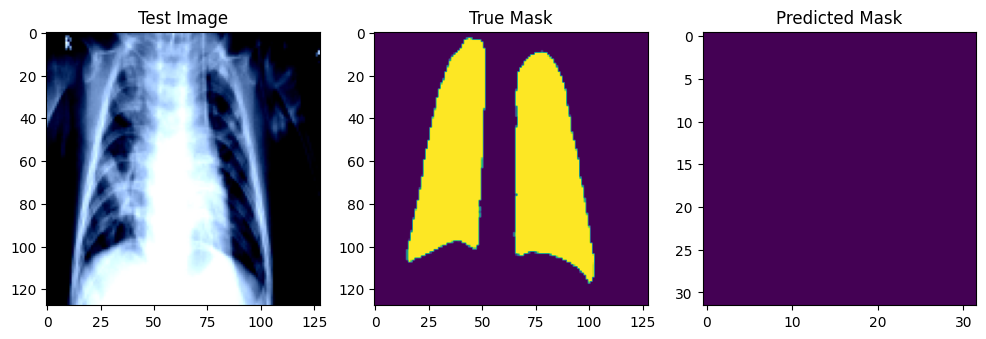

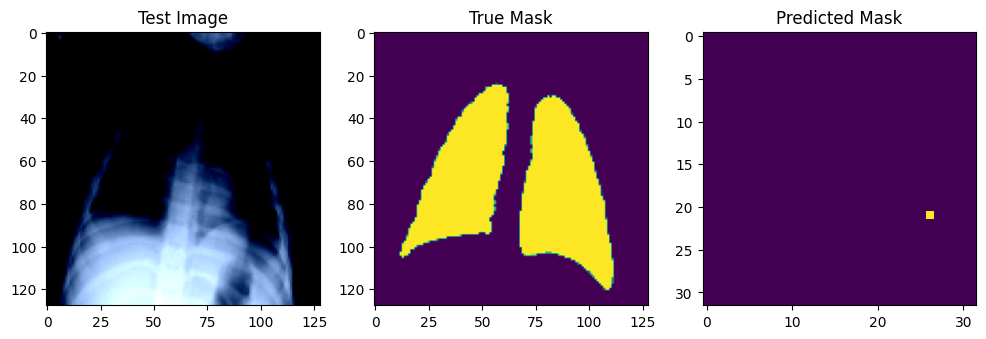

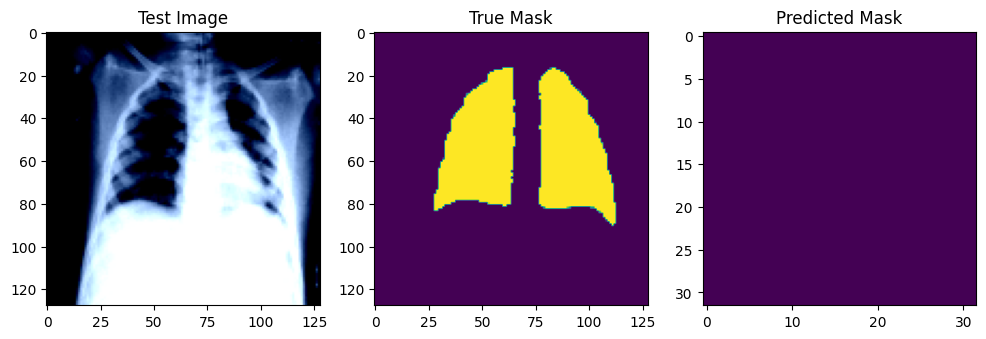

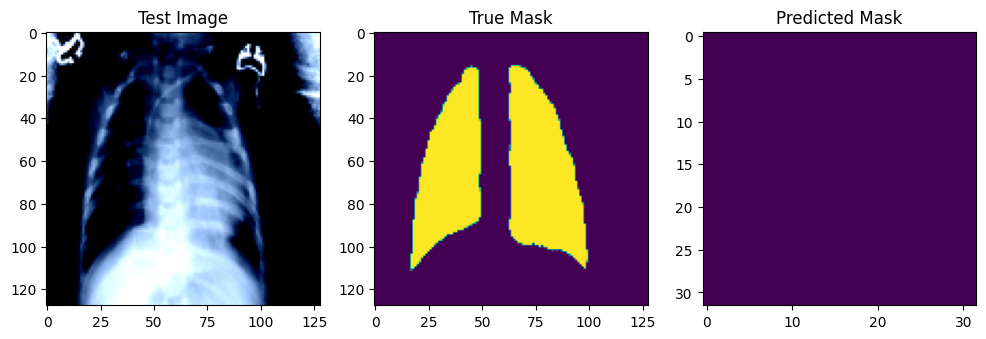

In [133]:
val_metrics(darwin_metrics)
image_display(darwin_model, darwin_test)

### Part 2: Shenzhen Dataset

In [109]:
val_metrics(shenzhen_metrics)

Validation Metrics: IoU: 0.5596947679628751, Accuracy: 0.745840345110212, Precision: 0.5596947679628751, Recall: 0.745840345110212, F1 Score: 0.6385478281128542


### Part 3: Covid-19 Dataset

In [110]:
val_metrics(covid_metrics)

Validation Metrics: IoU: 0.5758501912815778, Accuracy: 0.7552064011216829, Precision: 0.5758501912815778, Recall: 0.7552064011216829, F1 Score: 0.6519997052294929
